<h1>
<font color="#ff2e2e">
Corner Detection
</font>
</h1>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

<h3><font color = "#079e05"> This function is used to plot your result </font></h3>

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

<h3><font color = "#079e05"> Complete the harris_points function without using OpenCV functions </font></h3>

In [20]:
def harris_points(image):
    '''
    Gets corner points by applying the harris detection algorithm.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result image.
    '''    
    result = image.copy()
    
    #############
    # Your code #
    # convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = np.float64(gray_image)

    # calculate Ix and Iy with Sobel
    Ix = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3) # cv2.CV_64F is float64
    Iy = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3) # ksize=5

    # calculate Ix2, Iy2 and Ixy
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    # Apply Gaussian filter (window effect)
    Gx2 = cv2.GaussianBlur(Ix2, (3, 3), 0)
    Gy2 = cv2.GaussianBlur(Iy2, (3, 3), 0)
    Gxy = cv2.GaussianBlur(Ixy, (3, 3), 0)

    # calculate R
    R = np.zeros(gray_image.shape)
    k = 0.04 # 0.02
    
    # loop implementation
    # for i in range(gray_image.shape[0]):
    #     for j in range(gray_image.shape[1]):
    #         M = np.array([[Gx2[i, j], Gxy[i, j]], [Gxy[i, j], Gy2[i, j]]])
    #         R[i, j] = np.linalg.det(M) - k * (np.trace(M) ** 2)
    
    # without loop implementation
    M = np.stack((Gx2, Gxy, Gxy, Gy2), axis=-1).reshape(gray_image.shape[0], gray_image.shape[1], 2, 2)
    det_M = np.linalg.det(M)
    trace_M = np.trace(M, axis1=2, axis2=3)
    R = det_M - k * (trace_M ** 2)

    # non-maximum suppression
    R = cv2.dilate(R, None)
    
    # # draw corners
    threshold = 0.01 * R.max() # or .005 or .001 could be
    # find the coordinates of the points whose dst value is greater than threshold
    y, x = np.where(R > threshold)
    # draw circles around the coordinates
    result[y, x] = [0, 0, 255]
    for i in range(len(y)):
        cv2.circle(result, (x[i], y[i]), 4, (0, 0, 255), 4)
    
    #############
    
    return result[:, :, ::-1]

<h3><font color = "#079e05"> Show the result </font></h3>

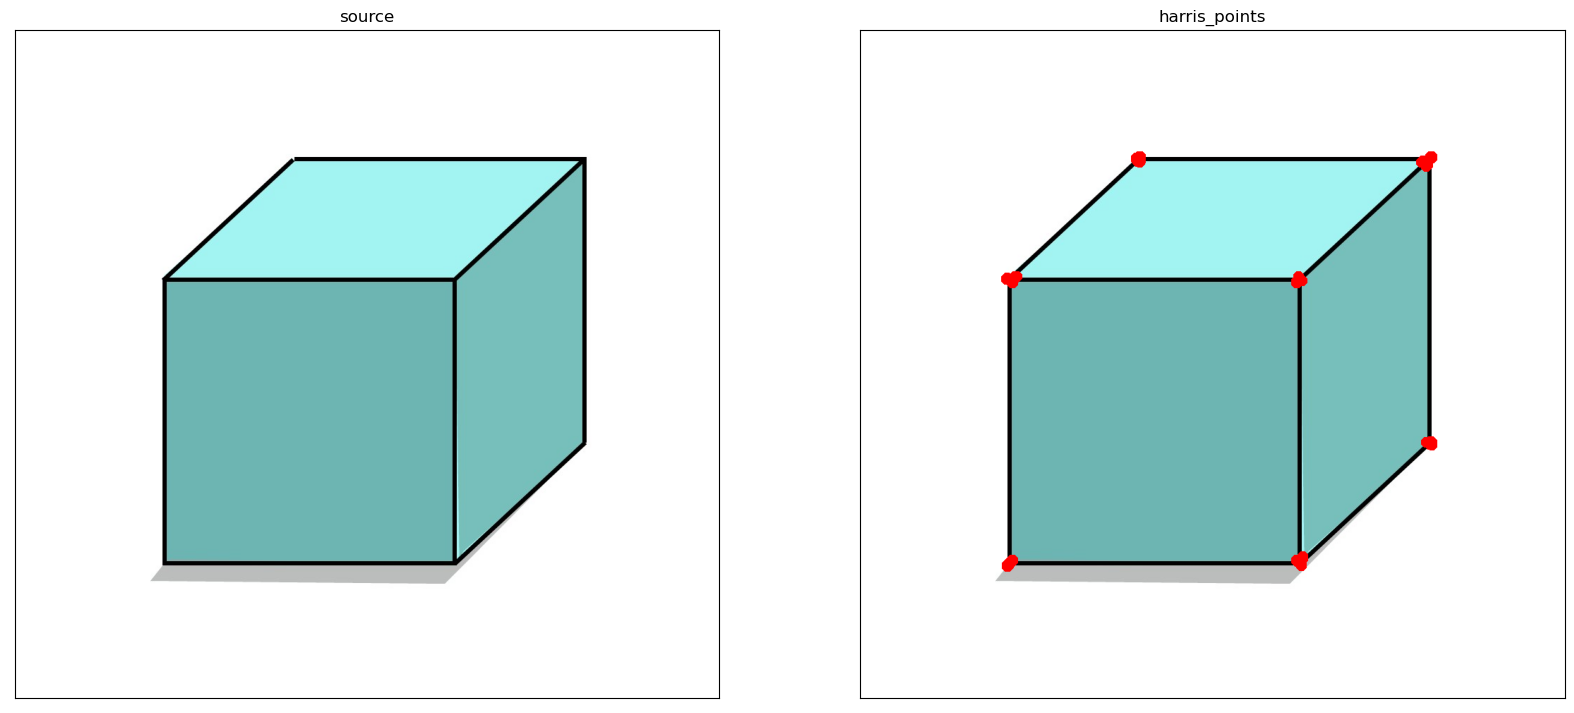

In [24]:
image_list = []
image = cv2.imread(os.path.join('images/Q5', 'harris.jpg'))
image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'source', 'img'])
image_list.append([harris_points(image), 'harris_points', 'img'])
plotter(image_list,1 , 2, True, 20, 10, '7')

<h3><font color = "#079e05"> Complete the harris_points_OpenCV function with using OpenCV functions </font></h3>

In [22]:
def harris_points_OpenCV(image):
    '''
    Gets corner points by applying the harris detection algorithm.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The result image.
    '''  
    
    #############
    # Your code #
    # src: https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

    # convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # convert to float32
    gray_image = np.float32(gray_image)

    # apply harris detection algorithm
    dst = cv2.cornerHarris(gray_image, 2, 5, 0.02) # params: img (single-channel float32 image), blockSize, ksize, k

    # result is dilated for marking the corners, not important (non-max supression)
    dst = cv2.dilate(dst, None) # in dst(corners:white, edges: black, flat: gray), dilate the white areas

    ## draw corners on the image with 2 methods
    # 1.
    # Threshold for an optimal value, it may vary depending on the image.
    # image[dst > 0.01 * dst.max()] = [0, 0, 255] # or .005 or .001 could be
    # 2.
    # threshold value
    threshold = 0.01 * dst.max() # or .005 or .001 could be
    # find the coordinates of the points whose dst value is greater than threshold
    y, x = np.where(dst > threshold)
    # draw circles around the coordinates
    image[y, x] = [0, 0, 255]
    for i in range(len(y)):
        cv2.circle(image, (x[i], y[i]), 4, (0, 0, 255), 4)

    result = image[:, :, ::-1] # BGR to RGB
    #############
    return result

<h3><font color = "#079e05"> Show the result </font></h3>

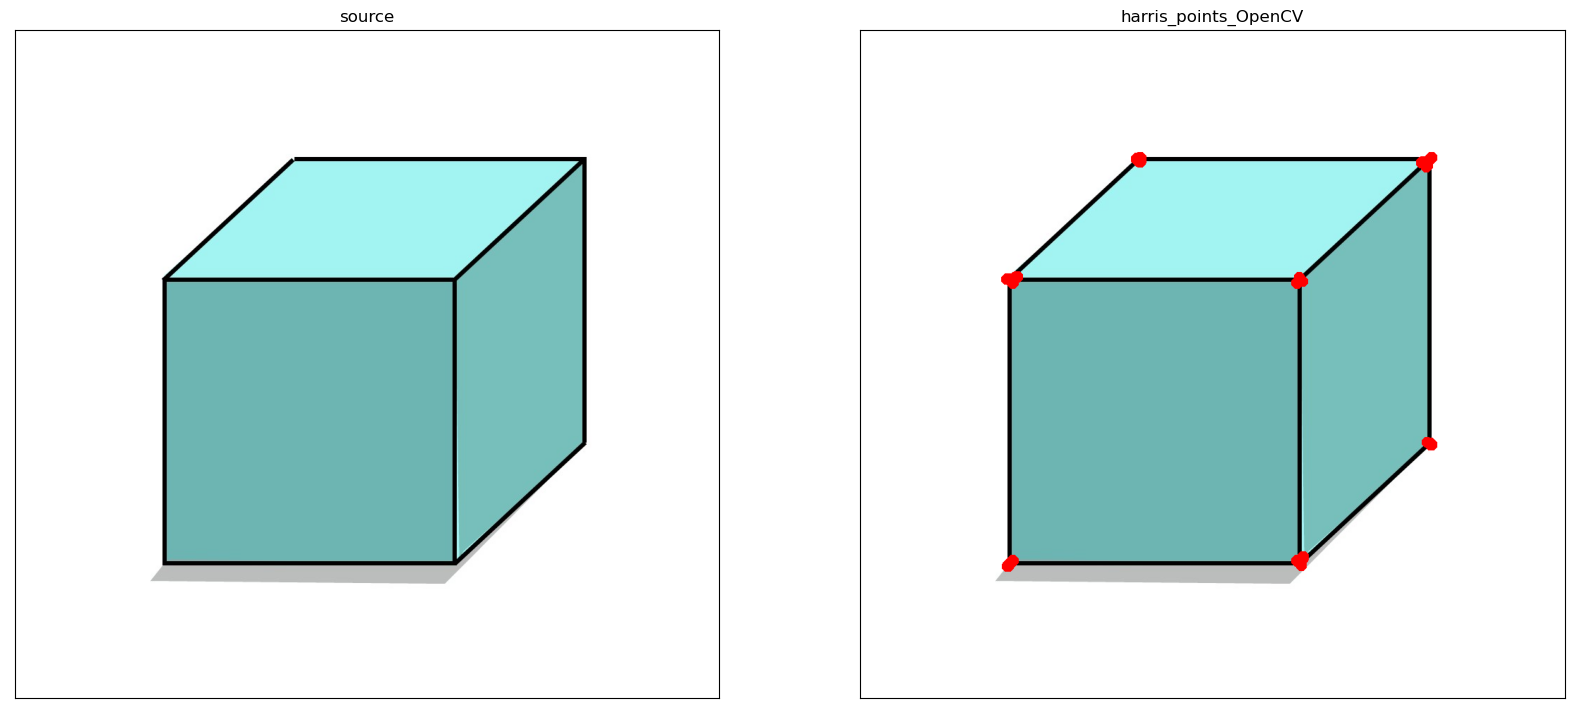

In [23]:
image_list = []
image = cv2.imread(os.path.join('images/Q5', 'harris.jpg'))
image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'source', 'img'])
image_list.append([harris_points_OpenCV(image), 'harris_points_OpenCV', 'img'])
plotter(image_list,1 , 2, True, 20, 10, '7')

<div dir="rtl">
    <h1>
        مقایسه نتایج
    </h1>
    همان طور که دیده می شود خروجی هر دو تابع یکسان است و نتیجه مشابهی دارند
</div>

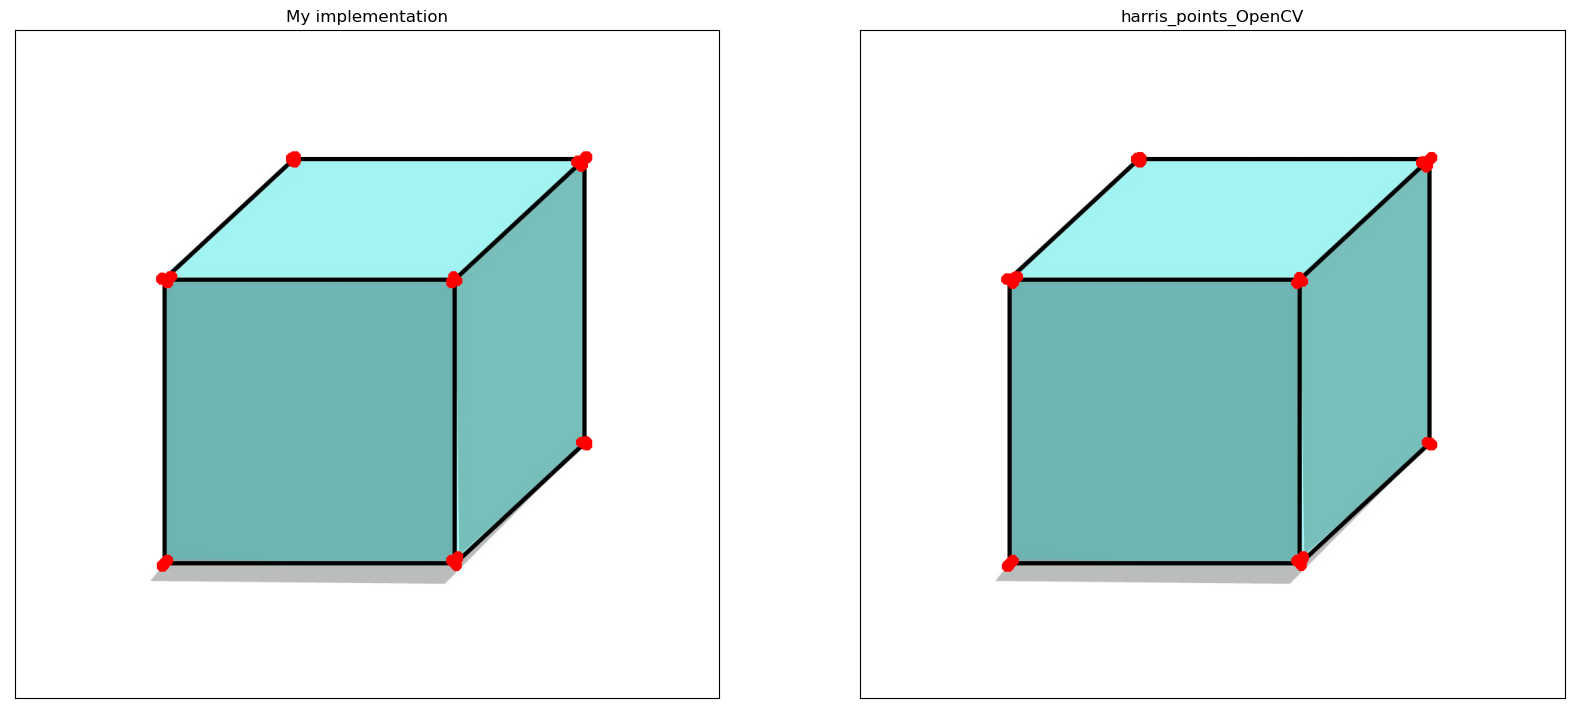

In [25]:
image_list = []
image_list.append([harris_points(image), 'My implementation', 'img'])
image_list.append([harris_points_OpenCV(image), 'harris_points_OpenCV', 'img'])
plotter(image_list,1 , 2, True, 20, 10, '7')